<a href="https://colab.research.google.com/github/danielfrgs/2022_1-Datos-Masivos-I/blob/main/Proyectos/P1/P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Proyecto

- Daniel Fragoso Alvarado
- Hugo Rangel Ramirez
- Jesus Enrique Gomez Martinez

datos: https://www.cs.cmu.edu/~ark/personas/

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 36 kB/s 
     |████████████████████████████████| 198 kB 25.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=9ae12922ec111b82cd999da63d61935a131fbee3437077573c015b3a2e80c4fd
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
# Librerias
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=200)

import cufflinks as cf
import pandas as pd
import pyspark
# Cargar Funciones Extra
from pyspark.sql.functions import * 
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Proyecto_1').getOrCreate()

<Figure size 1600x1200 with 0 Axes>

In [ ]:
#Carga de bibliotecas extras
import numpy as np
import matplotlib.pyplot as plt

#Carga de NLTK
import nltk
import nltk
nltk.download('stopwords')
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Sobre los Datos:

La Base de Datos agrupa **42,306** resúmenes de tramas de películas extraídos de Wikipedia + metadatos alineados extraídos de Freebase, que incluyen:
- Ingresos de taquilla de películas, género, fecha de lanzamiento, tiempo de ejecución e idioma
- Nombres de personajes e información alineada sobre los actores que los interpretan, incluido el género y la edad estimada en el momento del estreno de la película.

En total el conunto de datos se conforma de 5 archivos, 2 de ellos en formato `.tsv` y el resto en `.txt`. Debido a la forma en que estaban conformdas, para darle un formarto util para nuestro análisis debemos de generar funciones axiliares que ayuden a su lectura:

Generación de Funciones auxiliares para limpiar algunos registros que se utilizaran posteriormente.

In [ ]:
# Lectura de datos TSV
def read_tsv(direccion):
    import csv
    tsv_file = open(direccion)
    read_tsv = csv.reader(tsv_file, delimiter= "\t")
    lista = [row for row in read_tsv]
    tsv_file.close()
    return(spark.sparkContext.parallelize(lista))

# Lectura de datos TXT
def read_txt(direccion):
    import csv
    txt_file = open(direccion)
    read_tsv = csv.reader(txt_file, delimiter= "\t")
    lista = [row for row in read_tsv]
    txt_file.close()
    return(spark.sparkContext.parallelize(lista))

In [ ]:
# Importamos datos:

character = read_tsv('character.metadata.tsv')
movie = read_tsv('movie.metadata.tsv')

In [ ]:
name = read_txt('name.clusters.txt')
tvtropes = read_txt('tvtropes.clusters.txt')
plot_summaries =read_txt('plot_summaries.txt')

A pesar de haber generado la lectura debido a su formato original, no son compatibles con muchos de los recursos de Map, por lo que hay que generar una función auxiliar que nos permita limpiar los registros.

Ejemplo:

In [ ]:
for x in movie.take(1):
    print(x)

['975900', '/m/03vyhn', 'Ghosts of Mars', '2001-08-24', '14010832', '98.0', '{"/m/02h40lc": "English Language"}', '{"/m/09c7w0": "United States of America"}', '{"/m/01jfsb": "Thriller", "/m/06n90": "Science Fiction", "/m/03npn": "Horror", "/m/03k9fj": "Adventure", "/m/0fdjb": "Supernatural", "/m/02kdv5l": "Action", "/m/09zvmj": "Space western"}']


## ¿Cual es género más visto?

In [ ]:
# Función que divide los géneros.

def sep_gen(renglon):
    renglon_separado = renglon[8]
    import re
    generos = re.findall(r'"([\w\s]+)"', renglon_separado)
    for g in generos:
        yield g

In [ ]:
genere = movie.flatMap(sep_gen)
genere = genere.map(lambda renglon: (renglon, 1))
# Conteo
genere_count = genere.reduceByKey(lambda val_1 , val_2: val_1 + val_2).sortBy(lambda renglon: renglon[1], ascending = False)

In [ ]:
genere_count.take(10)

[('Drama', 34007),
 ('Comedy', 16349),
 ('Romance Film', 10234),
 ('Action', 8798),
 ('Thriller', 8744),
 ('Short Film', 8141),
 ('World cinema', 7155),
 ('Crime Fiction', 6948),
 ('Indie', 6897),
 ('Documentary', 5630)]

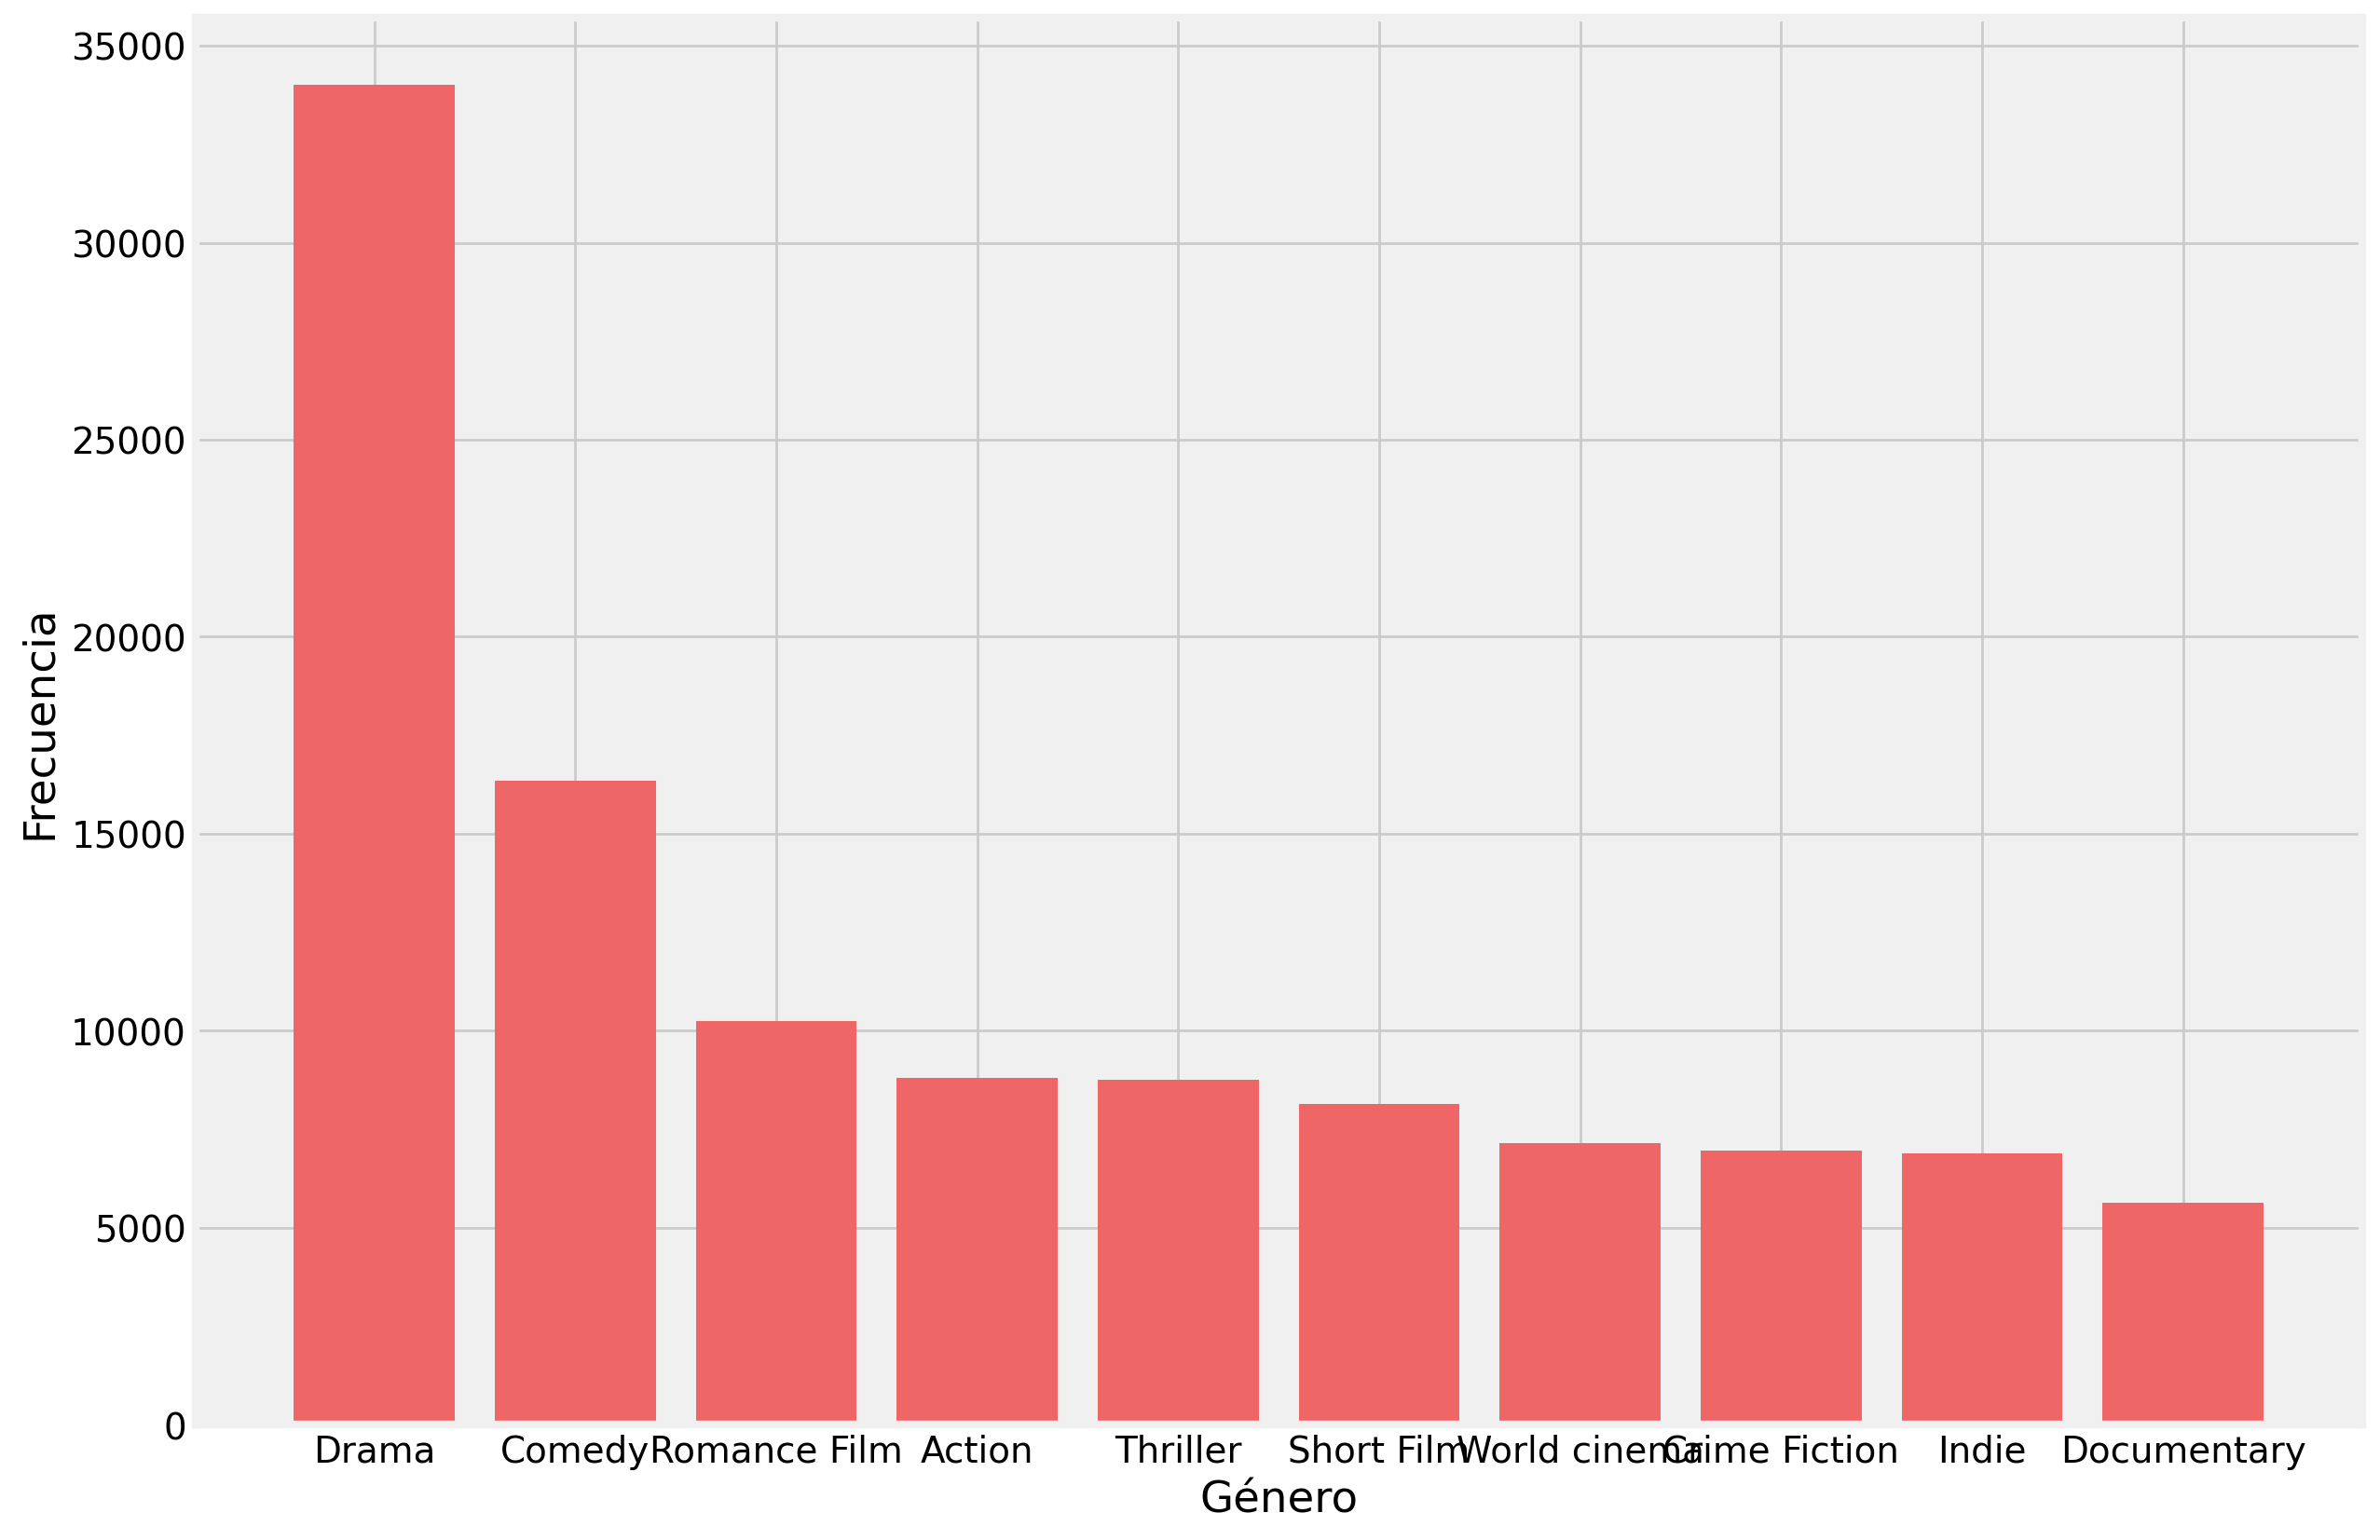

In [ ]:
histograma = genere_count.take(10)#.collect()
numeros = [ numero for (numero, _) in histograma ]
frecuencias = [ frecuencia for (_, frecuencia) in histograma ]

figure(figsize=(15, 10), dpi=200)
with plt.style.context('fivethirtyeight'):
    plt.bar(numeros, frecuencias, color='#EE6666')

plt.xlabel('Género')
plt.ylabel('Frecuencia')
plt.show()
figsize =(10, 7)

## La palabra más larga de las descripciones




In [ ]:
# Generamos una función que compare la longitud de un string:

# Comparación de Strings
def com_string(x, y):
    if len(x) > len(y):
        return x
    return y

#Al hacer un analsiis exploratorio nos percatamos que algunas sinopsis contaban 
# con url's, por lo que procedimos a eliminar estos valores mediante una función:

#Eliminacion de url's
def del_url(renglon):
    import re
    generos = re.sub(r'http\S+', ' ', renglon)
    return generos

In [ ]:
desc = plot_summaries.map(lambda x: x[1])
desc = desc.map(del_url)

In [ ]:
# Reduzcammos a palabras

words = desc.map(lambda x: x.split(' '))

#Eliminamos signos de puntuación y espacios en blanco
import string
def removePunctuationsFunct(x):
    list_punct=list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered

#Removemos stopwords (palabras vacias)
def removeStopWordsFunct(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('english'))
    filteredSentence = [w for w in x if not w in stop_words]
    return filteredSentence

words = words.map(removeStopWordsFunct)
words = words.map(removePunctuationsFunct)


In [ ]:
def sep(renglon):
    for g in renglon:
        return g

words_sep = words.map(sep)

In [ ]:
word_legth = words_sep.reduce(com_string)

In [ ]:
word_legth

'PlotdatePrologueThursdayMondaySaturdayTuesdayFridaySundayWednesdayEpilogue'

## Contar el número de veces que aparece la palabra 'war' en la descripción 

In [ ]:
cont = plot_summaries.map(lambda x: (x[0], x[1].split(' ')))
cont = cont.map(lambda x: (x[0], removeStopWordsFunct(x[1])))
cont = cont.map(lambda x: (x[0], removePunctuationsFunct(x[1])))

In [ ]:
cont_war = cont.map(lambda x: (x[0], x[1].count('war')))

In [ ]:
cont_war = cont_war.sortBy(lambda renglon: renglon[1], ascending = False)

In [ ]:
cont_war.take(5)

[('886892', 10),
 ('3843721', 9),
 ('3653120', 8),
 ('3903364', 8),
 ('1432805', 8)]

In [ ]:
war_movies = cont_war.filter(lambda renglon: renglon[1] > 1)

## ¿Cual es la película que más menciona 'war' en su descripción?

In [ ]:
movie.filter(lambda x: x[0] == '886892').take(1)

[['886892',
  '/m/03lv4x',
  'Breaker Morant',
  '1980',
  '4735000',
  '107.0',
  '{"/m/02h40lc": "English Language"}',
  '{"/m/0chghy": "Australia", "/m/0ctw_b": "New Zealand"}',
  '{"/m/01fc50": "Anti-war", "/m/0hj3mx2": "British Empire Film", "/m/03g3w": "History", "/m/04xvlr": "Period piece", "/m/07s9rl0": "Drama", "/m/082gq": "War film", "/m/07k67c": "Anti-war film", "/m/05bh16v": "Courtroom Drama"}']]

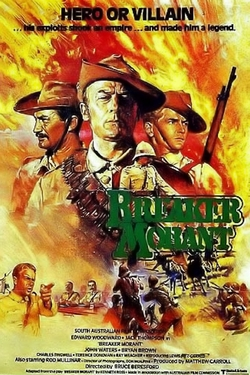

## ¿De que país provienen principalmente las películas de guerra?

In [ ]:
war_movies.take(5)

[('886892', 10),
 ('3843721', 9),
 ('3653120', 8),
 ('3903364', 8),
 ('1432805', 8)]

In [ ]:
country = movie.map(lambda x: (x[0], x[7]))
country.take(1)

[('975900', '{"/m/09c7w0": "United States of America"}')]

In [ ]:
country_war = country.join(war_movies)

In [ ]:
def sep_gen_2(renglon):
    renglon_separado = renglon[0]
    import re
    generos = re.findall(r'"([\w\s]+)"', renglon_separado)
    for g in generos:
        yield g

In [ ]:
country_war = country_war.flatMap(lambda x: sep_gen_2(x[1]))

In [ ]:
country_war_cont = country_war.map(lambda x: (x, 1)).reduceByKey(lambda val_1 , val_2: val_1 + val_2).sortBy(lambda renglon: renglon[1], ascending = False)

In [ ]:
country_war_cont.take(10)

[('United States of America', 357),
 ('United Kingdom', 108),
 ('France', 61),
 ('Germany', 52),
 ('Japan', 49),
 ('Italy', 35),
 ('India', 34),
 ('Canada', 26),
 ('Australia', 17),
 ('Russia', 15)]

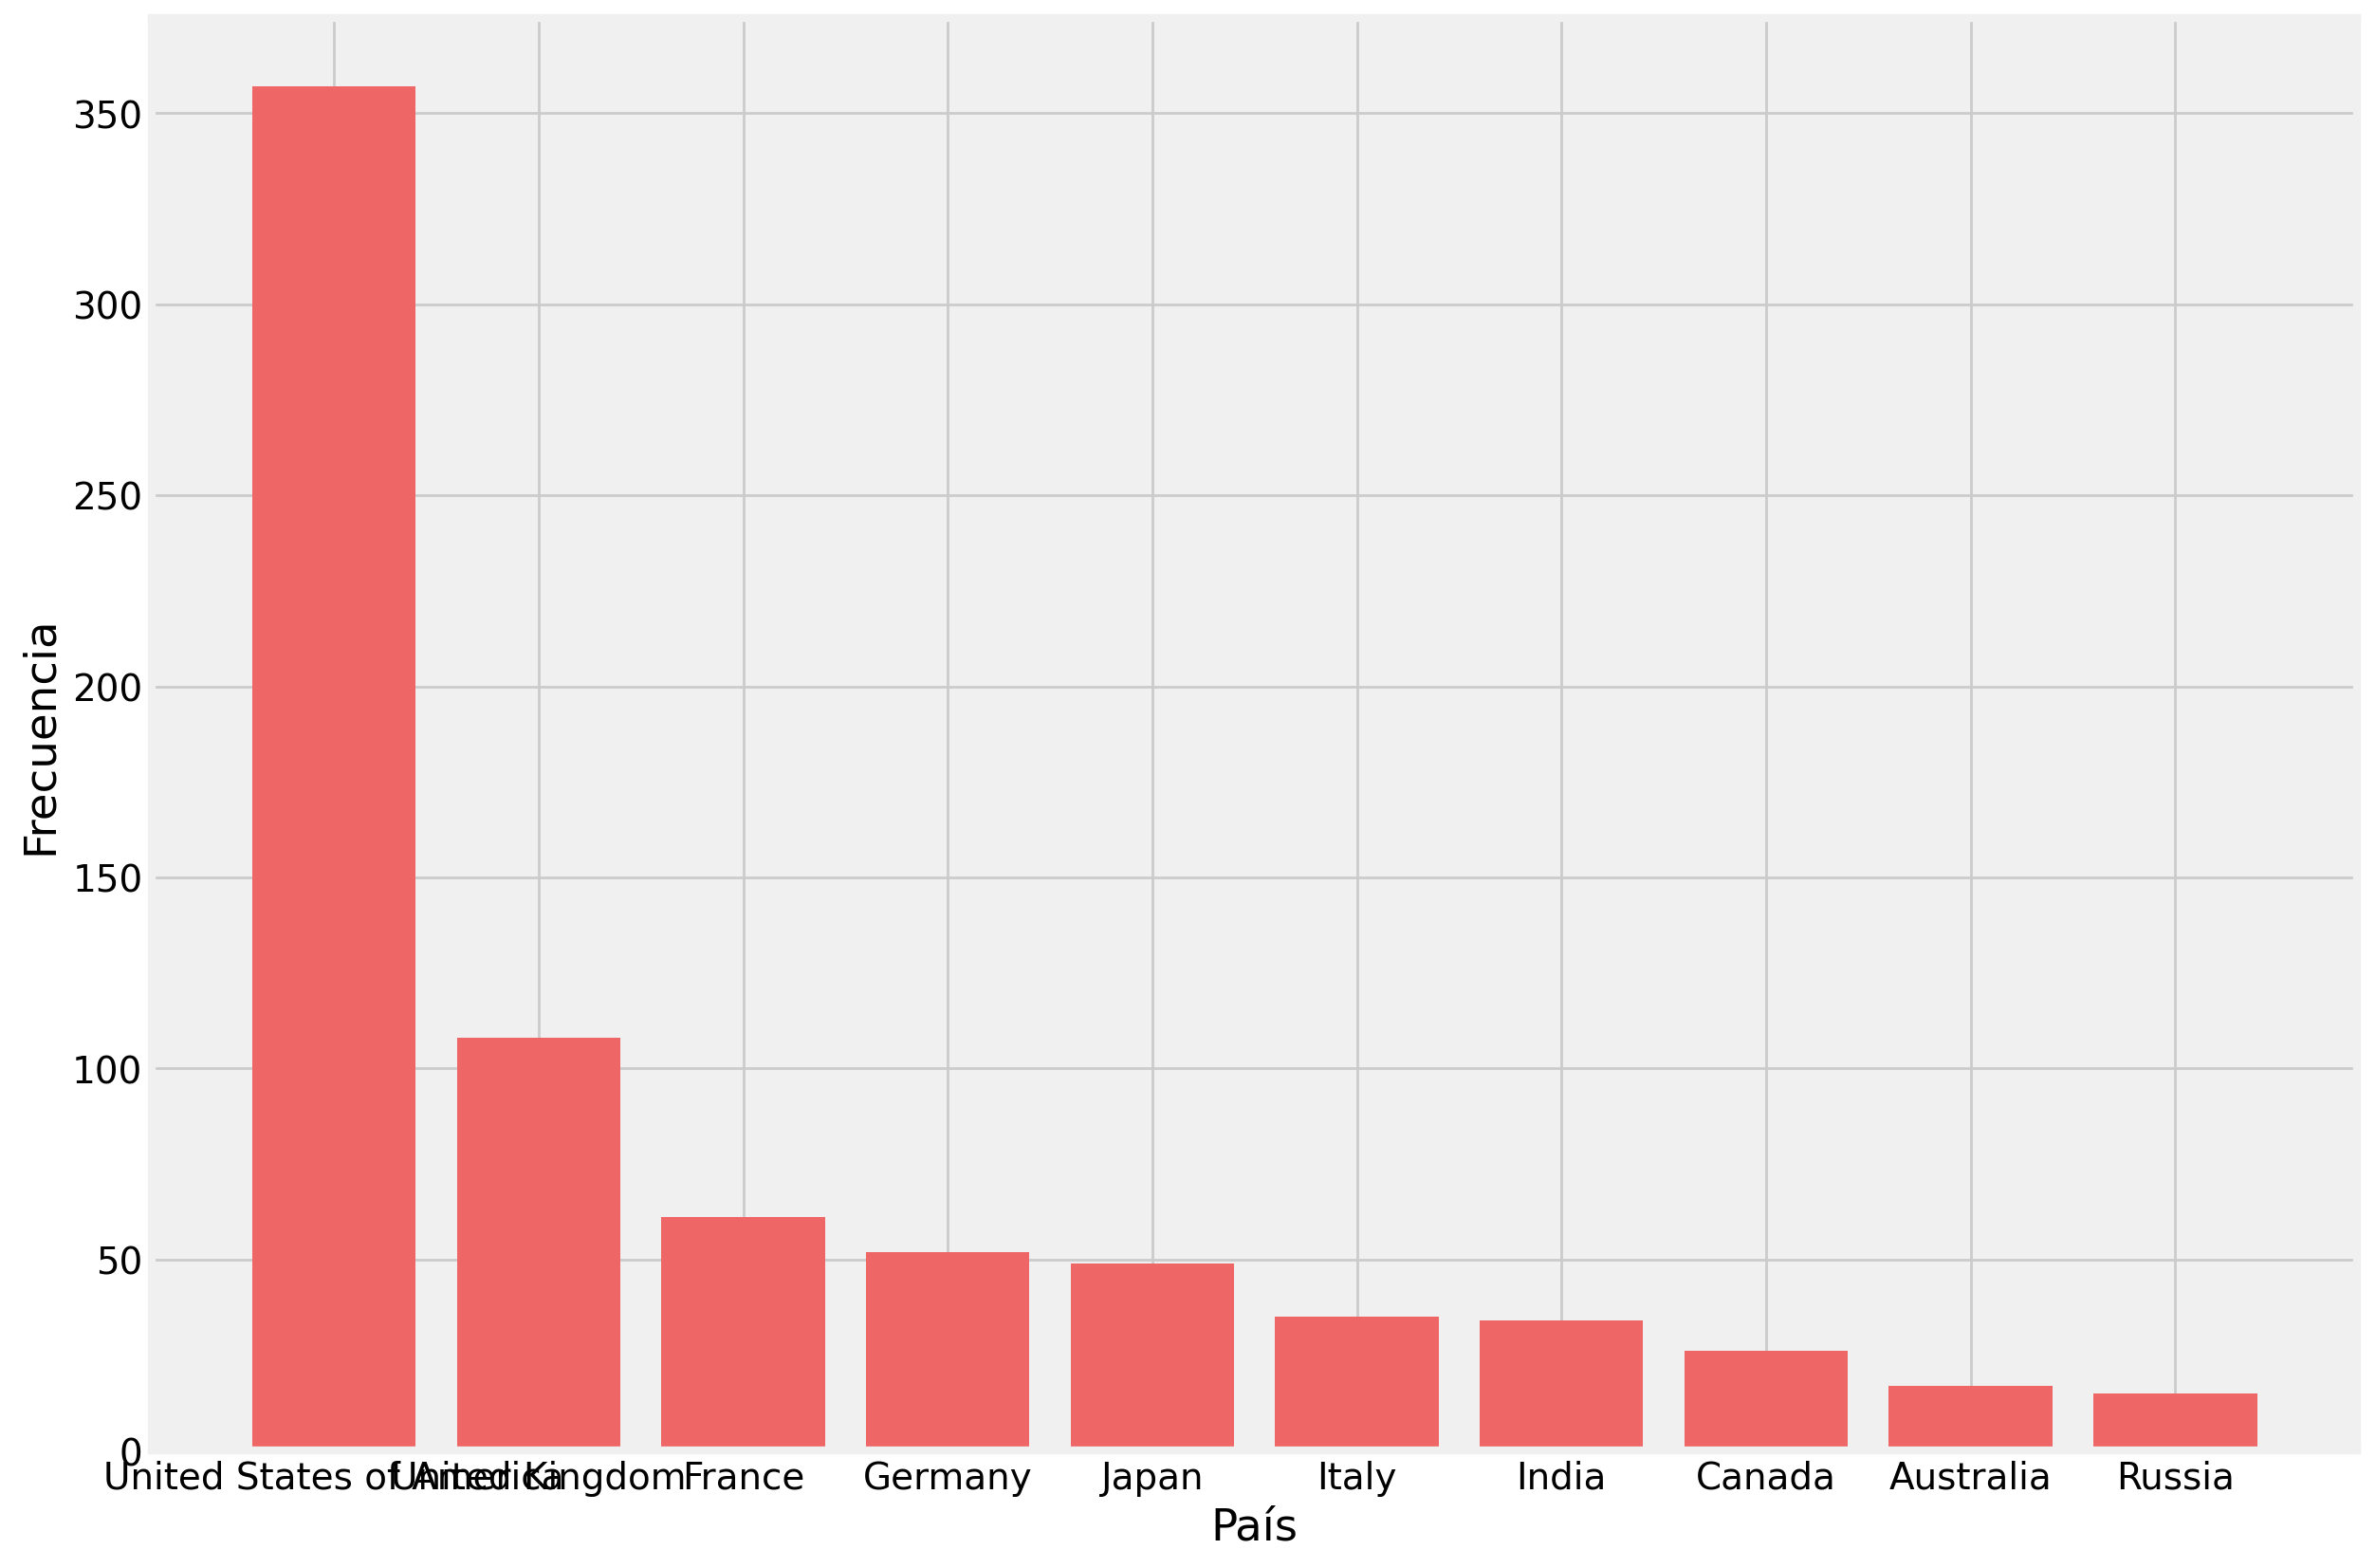

In [ ]:
histograma = country_war_cont.take(10)#.collect()
numeros = [ numero for (numero, _) in histograma ]
frecuencias = [ frecuencia for (_, frecuencia) in histograma ]

figure(figsize=(15, 10), dpi=200)
with plt.style.context('fivethirtyeight'):
    plt.bar(numeros, frecuencias, color='#EE6666')

plt.xlabel('País')
plt.ylabel('Frecuencia')
plt.show()
figsize =(10, 7)

## ¿En qué año se estrenaron más películas y cuanto recaudó cada una?

In [ ]:
year = movie.map(lambda x: (x[3], x[4]))
year.take(10)

[('2001-08-24', '14010832'),
 ('2000-02-16', ''),
 ('1988', ''),
 ('1987', ''),
 ('1983', ''),
 ('1913-05-29', ''),
 ('2002', ''),
 ('1938-08-16', '3600000'),
 ('1974', ''),
 ('1960', '')]

In [ ]:
# Generammos la función para obtener los años y montos

def año(renglon):
    import re
    año = re.findall(r'.*([1-3][0-9]{3})', renglon[0])
    try:
        ren = int(float(renglon[1]))
    except:
        ren = 0
    for x in año:
        return(x, (ren, 1))

In [ ]:
prueb = year.map(año).filter(lambda x: x is not None)
prueb.take(5)

[('2001', (14010832, 1)),
 ('2000', (0, 1)),
 ('1988', (0, 1)),
 ('1987', (0, 1)),
 ('1983', (0, 1))]

In [ ]:
year_count = prueb.reduceByKey(lambda x, y: (x[0]+y[0],x[1]+y[1]))
year_count.take(5)

[('1983', (2604953274, 666)),
 ('1913', (0, 272)),
 ('2002', (17217637693, 1478)),
 ('1938', (23507371, 518)),
 ('1964', (336761097, 567))]

In [ ]:
# Gráfica
import plotly.graph_objects as px 
import numpy as np 
import plotly.io as pio
pio.templates

plot = px.Figure(data=[px.Scatter( 
    x = year_count.map(lambda x: int(x[0])).collect(), 
    y = year_count.map(lambda x: x[1][1]).collect(), 
    mode = 'markers', 
    #marker_size = year_count.map(lambda x: x[1][0]/1000000).collect()
    ) 
])

plot.show()

In [ ]:
# Gráfica

plot = px.Figure(data=[px.Scatter( 
    x = year_count.map(lambda x: int(x[0])).collect(), 
    y = year_count.map(lambda x: x[1][1]).collect(),
    mode = 'markers', 
    marker = dict( 
        color=year_count.map(lambda x: x[1][0]).collect(),
        size= year_count.map(lambda x: x[1][0]/600000000).collect(), 
        #sizemode='area', 
        #sizeref=2.*max(size)/(40.**2), 
        sizemin=4,
       # size_max=60,
        showscale=True
    )
    ) 
])

plot.show()

# Preprocesamiento de los datos

El conjunto de datos `plot summaries` contiene dos columnas; la primera es el identificador de la película y la segunda es una sinópsis de ésta. Las sinópsis fueron recolectadas de Wikipedia, es decir, está en lenguaje natural, por lo que se necesita primero un preprocesamiento que permita extraer las palabras clave en cada reseña. A continuación se muestra ese proceso:

In [ ]:
# Visualización de RDD con datos
for letra in plot_summaries.take(5):
  print(letra)

['23890098', "Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."]
['31186339', 'The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl  between the ages of 12 and 18 selected by lottery  for the annual Hunger Games. The tributes must fight to the death in an arena; the sole survivor is rewarded with fame and wealth. In her first Reaping, 12-year-old Primrose Everdeen is chosen from District 12. Her older sister Katniss volunteers to take her place. Peeta Mellark, a baker\'s son who once gave Katniss bread when she was starving, is the other District 12 tribute. Katniss and Peeta are taken to the Capitol, accompanied by their frequently drunk mentor, past victor Haymitch Abernathy. He warns them about the "Career" tributes who train intensively at special acad

In [ ]:
# Transformar textos a minúsculas y descartar el id de película
plot_summaries_minus = plot_summaries.map(lambda x: (x[1].lower()))

for letra in plot_summaries_minus.take(5):
  print(letra)

shlykov, a hard-working taxi driver and lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.
the nation of panem consists of a wealthy capitol and twelve poorer districts. as punishment for a past rebellion, each district must provide a boy and girl  between the ages of 12 and 18 selected by lottery  for the annual hunger games. the tributes must fight to the death in an arena; the sole survivor is rewarded with fame and wealth. in her first reaping, 12-year-old primrose everdeen is chosen from district 12. her older sister katniss volunteers to take her place. peeta mellark, a baker's son who once gave katniss bread when she was starving, is the other district 12 tribute. katniss and peeta are taken to the capitol, accompanied by their frequently drunk mentor, past victor haymitch abernathy. he warns them about the "career" tributes who train intensively at special academies and almost always win. du

In [ ]:
# Separar texto por palabra
plot_summaries_sep = plot_summaries_minus.map(lambda x: (x.split(' ')))

for letra in plot_summaries_sep.take(5):
  print(letra)

['shlykov,', 'a', 'hard-working', 'taxi', 'driver', 'and', 'lyosha,', 'a', 'saxophonist,', 'develop', 'a', 'bizarre', 'love-hate', 'relationship,', 'and', 'despite', 'their', 'prejudices,', 'realize', 'they', "aren't", 'so', 'different', 'after', 'all.']
['the', 'nation', 'of', 'panem', 'consists', 'of', 'a', 'wealthy', 'capitol', 'and', 'twelve', 'poorer', 'districts.', 'as', 'punishment', 'for', 'a', 'past', 'rebellion,', 'each', 'district', 'must', 'provide', 'a', 'boy', 'and', 'girl', '', 'between', 'the', 'ages', 'of', '12', 'and', '18', 'selected', 'by', 'lottery', '', 'for', 'the', 'annual', 'hunger', 'games.', 'the', 'tributes', 'must', 'fight', 'to', 'the', 'death', 'in', 'an', 'arena;', 'the', 'sole', 'survivor', 'is', 'rewarded', 'with', 'fame', 'and', 'wealth.', 'in', 'her', 'first', 'reaping,', '12-year-old', 'primrose', 'everdeen', 'is', 'chosen', 'from', 'district', '12.', 'her', 'older', 'sister', 'katniss', 'volunteers', 'to', 'take', 'her', 'place.', 'peeta', 'mellark

In [ ]:
# Quitar los signos de puntuación 
import string
def removePunctuationsFunct(x):
    list_punct=list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered

plot_summaries_punct = plot_summaries_sep.map(removePunctuationsFunct)

for palabra in plot_summaries_punct.take(5):
  print(palabra)

['shlykov', 'a', 'hardworking', 'taxi', 'driver', 'and', 'lyosha', 'a', 'saxophonist', 'develop', 'a', 'bizarre', 'lovehate', 'relationship', 'and', 'despite', 'their', 'prejudices', 'realize', 'they', 'arent', 'so', 'different', 'after', 'all']
['the', 'nation', 'of', 'panem', 'consists', 'of', 'a', 'wealthy', 'capitol', 'and', 'twelve', 'poorer', 'districts', 'as', 'punishment', 'for', 'a', 'past', 'rebellion', 'each', 'district', 'must', 'provide', 'a', 'boy', 'and', 'girl', '', 'between', 'the', 'ages', 'of', '12', 'and', '18', 'selected', 'by', 'lottery', '', 'for', 'the', 'annual', 'hunger', 'games', 'the', 'tributes', 'must', 'fight', 'to', 'the', 'death', 'in', 'an', 'arena', 'the', 'sole', 'survivor', 'is', 'rewarded', 'with', 'fame', 'and', 'wealth', 'in', 'her', 'first', 'reaping', '12yearold', 'primrose', 'everdeen', 'is', 'chosen', 'from', 'district', '12', 'her', 'older', 'sister', 'katniss', 'volunteers', 'to', 'take', 'her', 'place', 'peeta', 'mellark', 'a', 'bakers', '

In [ ]:
# Quitar las stop words
def removeStopWordsFunct(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('english'))
    filteredSentence = [w for w in x if not w in stop_words]
    return filteredSentence

plot_summaries_stop = plot_summaries_punct.map(removeStopWordsFunct)

for palabra in plot_summaries_stop.take(5):
  print(palabra)

['shlykov', 'hardworking', 'taxi', 'driver', 'lyosha', 'saxophonist', 'develop', 'bizarre', 'lovehate', 'relationship', 'despite', 'prejudices', 'realize', 'arent', 'different']
['nation', 'panem', 'consists', 'wealthy', 'capitol', 'twelve', 'poorer', 'districts', 'punishment', 'past', 'rebellion', 'district', 'must', 'provide', 'boy', 'girl', '', 'ages', '12', '18', 'selected', 'lottery', '', 'annual', 'hunger', 'games', 'tributes', 'must', 'fight', 'death', 'arena', 'sole', 'survivor', 'rewarded', 'fame', 'wealth', 'first', 'reaping', '12yearold', 'primrose', 'everdeen', 'chosen', 'district', '12', 'older', 'sister', 'katniss', 'volunteers', 'take', 'place', 'peeta', 'mellark', 'bakers', 'son', 'gave', 'katniss', 'bread', 'starving', 'district', '12', 'tribute', 'katniss', 'peeta', 'taken', 'capitol', 'accompanied', 'frequently', 'drunk', 'mentor', 'past', 'victor', 'haymitch', 'abernathy', 'warns', 'career', 'tributes', 'train', 'intensively', 'special', 'academies', 'almost', 'alwa

In [ ]:
# Quitar la cadena: "", que no aporta información 
def sin_espacios(documento):
  return([palabra for palabra in documento if palabra != ""])

plot_summaries_limpio = plot_summaries_stop.map(lambda x: sin_espacios(x))

for palabra in plot_summaries_limpio.take(5):
  print(palabra)

['shlykov', 'hardworking', 'taxi', 'driver', 'lyosha', 'saxophonist', 'develop', 'bizarre', 'lovehate', 'relationship', 'despite', 'prejudices', 'realize', 'arent', 'different']
['nation', 'panem', 'consists', 'wealthy', 'capitol', 'twelve', 'poorer', 'districts', 'punishment', 'past', 'rebellion', 'district', 'must', 'provide', 'boy', 'girl', 'ages', '12', '18', 'selected', 'lottery', 'annual', 'hunger', 'games', 'tributes', 'must', 'fight', 'death', 'arena', 'sole', 'survivor', 'rewarded', 'fame', 'wealth', 'first', 'reaping', '12yearold', 'primrose', 'everdeen', 'chosen', 'district', '12', 'older', 'sister', 'katniss', 'volunteers', 'take', 'place', 'peeta', 'mellark', 'bakers', 'son', 'gave', 'katniss', 'bread', 'starving', 'district', '12', 'tribute', 'katniss', 'peeta', 'taken', 'capitol', 'accompanied', 'frequently', 'drunk', 'mentor', 'past', 'victor', 'haymitch', 'abernathy', 'warns', 'career', 'tributes', 'train', 'intensively', 'special', 'academies', 'almost', 'always', 'wi

# Conteo de palabras, bigramas y trigramas totales



Una vez que ya se tienen los datos limpios, se procedrá a extraer información. En esta sección se contarán las ocurrencias totales por palabras, bigramas y trigramas en todos los documentos

In [ ]:
# Conteo de ourrencias totales de palabras
plot_summaries_palabras = plot_summaries_limpio.flatMap(lambda x: x) \
                                              .map(lambda x: (x,1)) \
                                              .reduceByKey(lambda a,b: a+b) \
                                              .sortBy(lambda x: x[1], ascending = False)

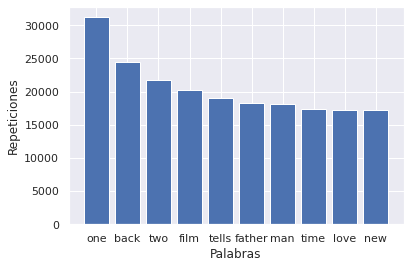

In [ ]:
# Graficación del conteo de palabras

import seaborn as sns
sns.set()

histograma = plot_summaries_palabras.take(10)
palabras = [ palabra for (palabra, _) in histograma ]
repeticiones = [ repeticiones for (_, repeticiones) in histograma ]
plt.bar(palabras, repeticiones)
plt.xlabel('Palabras')
plt.ylabel('Repeticiones')
plt.show()

In [ ]:
# Conteo de ourrencias totales de bigramas
plot_summaries_bigramas = plot_summaries_limpio.flatMap(lambda x: nltk.ngrams(x, 2)) \
                                              .map(lambda x: (x,1)) \
                                              .reduceByKey(lambda a, b: a + b) \
                                              .sortBy(lambda x: x[1], ascending = False)



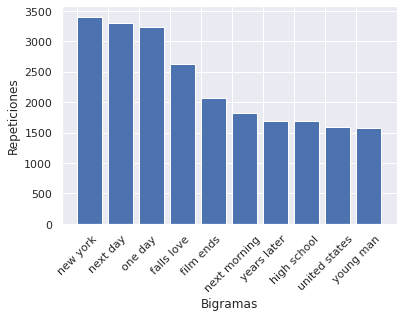

In [ ]:
# Graficación del conteo de bigramas
histograma = plot_summaries_bigramas.take(10)
bigramas = [ ' '.join(bigrama) for (bigrama, _) in histograma ]
repeticiones = [ repeticiones for (_, repeticiones) in histograma ]
plt.bar(bigramas, repeticiones, align='edge')
plt.xlabel('Bigramas')
plt.ylabel('Repeticiones')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Conteo de ourrencias totales de trigramas
plot_summaries_trigramas = plot_summaries_limpio.flatMap(lambda x: nltk.ngrams(x, 3)) \
                                              .map(lambda x: (x,1)) \
                                              .reduceByKey(lambda a, b: a + b) \
                                              .sortBy(lambda x: x[1], ascending = False)

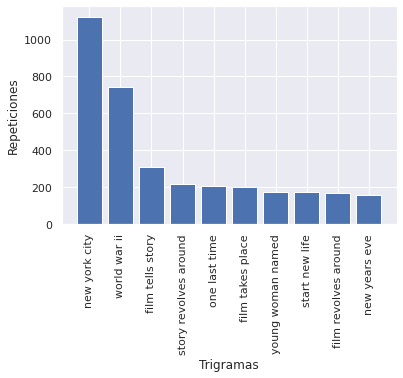

In [ ]:
# Graficación del conteo de trigramas
histograma = plot_summaries_trigramas.take(10)
trigramas = [ ' '.join(trigrama) for (trigrama, _) in histograma ]
repeticiones = [ repeticiones for (_, repeticiones) in histograma ]
plt.bar(trigramas, repeticiones)
plt.xlabel('Trigramas')
plt.ylabel('Repeticiones')
plt.xticks(rotation=90)
plt.show()

# Conteo de palabras, bigramas y trigramas por documento

In [ ]:
# Conteo de ourrencias por documento de palabras
plot_summaries_palabras_d = plot_summaries_limpio.flatMap(lambda x: list(set(x))) \
                                                 .map(lambda x: (x,1)) \
                                                 .reduceByKey(lambda a, b: a + b) \
                                                 .sortBy(lambda x: x[1], ascending = False)

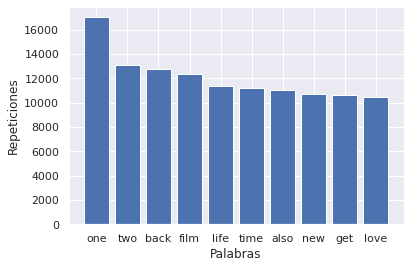

In [ ]:
# Graficación del conteo de palabras por documento
histograma = plot_summaries_palabras_d.take(10)
palabras = [ palabra for (palabra, _) in histograma ]
repeticiones = [ repeticiones for (_, repeticiones) in histograma ]
plt.bar(palabras, repeticiones)
plt.xlabel('Palabras')
plt.ylabel('Repeticiones')
plt.show()

In [ ]:
# Conteo de ourrencias por documento de bigramas
plot_summaries_bigramas_d =  plot_summaries_limpio.flatMap(lambda x: list(set(list(nltk.ngrams(x, 2))))) \
                                                   .map(lambda x: (x,1)) \
                                                   .reduceByKey(lambda a, b: a + b) \
                                                   .sortBy(lambda x: x[1], ascending = False)

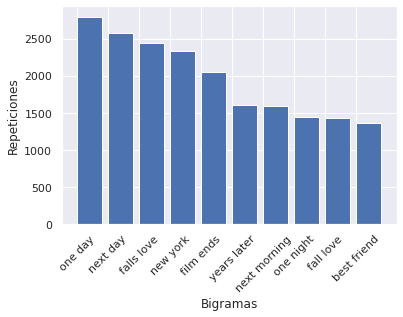

In [ ]:
# Graficación del conteo de bigramas por documento
histograma = plot_summaries_bigramas_d.take(10)
bigramas = [ ' '.join(bigrama) for (bigrama, _) in histograma ]
repeticiones = [ repeticiones for (_, repeticiones) in histograma ]
plt.bar(bigramas, repeticiones, align='edge')
plt.xlabel('Bigramas')
plt.ylabel('Repeticiones')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Conteo de ourrencias por documento de trigramas
plot_summaries_trigramas_d =  plot_summaries_limpio.flatMap(lambda x: list(set(list(nltk.ngrams(x, 3))))) \
                                                   .map(lambda x: (x,1)) \
                                                   .reduceByKey(lambda a, b: a + b) \
                                                   .sortBy(lambda x: x[1], ascending = False)

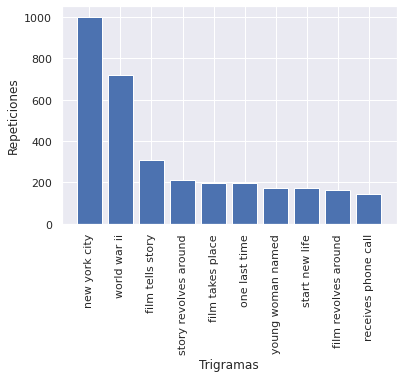

In [ ]:
# Graficación del conteo de bigramas por documento
histograma = plot_summaries_trigramas_d.take(10)
trigramas = [ ' '.join(trigrama) for (trigrama, _) in histograma ]
repeticiones = [ repeticiones for (_, repeticiones) in histograma ]
plt.bar(trigramas, repeticiones)
plt.xlabel('Trigramas')
plt.ylabel('Repeticiones')
plt.xticks(rotation=90)
plt.show()

# Comparación ocurrencias totales vs por documento

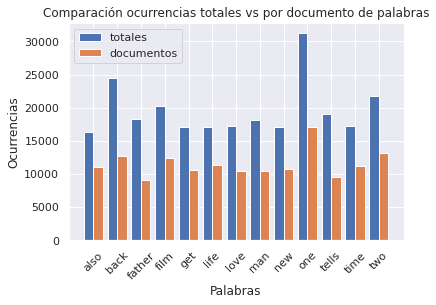

In [ ]:
# Gráfica de comparación ocurrencias totales vs por documento de palabras
palabras = ['one', 'back', 'two', 'film', 'tells', 'father',
            'man', 'time', 'love', 'new', 'life', 'also', 'get']
palabras.sort()

totales = plot_summaries_palabras.filter(lambda x: x[0] in palabras).sortBy(lambda x: x[0]).map(lambda x: x[1])
documentos = plot_summaries_palabras_d.filter(lambda x: x[0] in palabras).sortBy(lambda x: x[0]).map(lambda x: x[1])
  
X_axis = np.arange(len(palabras))
  
plt.bar(X_axis - 0.2, totales.collect(), 0.4, label = 'totales')
plt.bar(X_axis + 0.2, documentos.collect(), 0.4, label = 'documentos')
  
plt.xticks(X_axis, palabras)
plt.xlabel("Palabras")
plt.ylabel("Ocurrencias")
plt.title("Comparación ocurrencias totales vs por documento de palabras")
plt.xticks(rotation=45)
plt.legend()
plt.show()

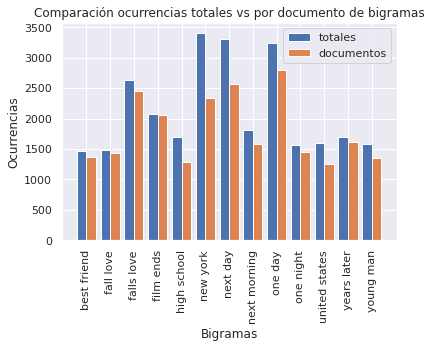

In [ ]:
# Gráfica de comparación ocurrencias totales vs por documento de bigramas
bigramas = ['new york', 'next day', 'one day', 'falls love', 'film ends', 
            'next morning', 'years later', 'high school', 'united states',
            'young man', 'one night', 'fall love', 'best friend']
bigramas.sort()

totales = plot_summaries_bigramas.filter(lambda x: ' '.join(x[0]) in bigramas).sortBy(lambda x: x[0]).map(lambda x: x[1])
documentos = plot_summaries_bigramas_d.filter(lambda x: ' '.join(x[0]) in bigramas).sortBy(lambda x: x[0]).map(lambda x: x[1])
  
X_axis = np.arange(len(bigramas))
  
plt.bar(X_axis - 0.2, totales.collect(), 0.4, label = 'totales')
plt.bar(X_axis + 0.2, documentos.collect(), 0.4, label = 'documentos')
  
plt.xticks(X_axis, bigramas)
plt.xlabel("Bigramas")
plt.ylabel("Ocurrencias")
plt.title("Comparación ocurrencias totales vs por documento de bigramas")
plt.xticks(rotation=90)
plt.legend()
plt.show()

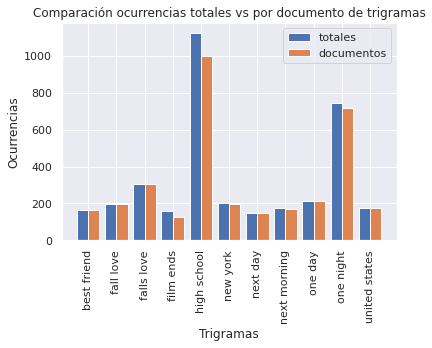

In [ ]:
# Gráfica de comparación ocurrencias totales vs por documento de trigramas
trigramas = ['new york city', 'world war ii', 'film tells story', 'story revolves around',
             'one last time', 'film takes place', 'young woman named', 'start new life',
             'film revolves around', 'new years eve', 'receives phone call']
trigramas.sort()

totales = plot_summaries_trigramas.filter(lambda x: ' '.join(x[0]) in trigramas).sortBy(lambda x: x[0]).map(lambda x: x[1])
documentos = plot_summaries_trigramas_d.filter(lambda x: ' '.join(x[0]) in trigramas).sortBy(lambda x: x[0]).map(lambda x: x[1])
  
X_axis = np.arange(len(trigramas))
  
plt.bar(X_axis - 0.2, totales.collect(), 0.4, label = 'totales')
plt.bar(X_axis + 0.2, documentos.collect(), 0.4, label = 'documentos')
  
plt.xticks(X_axis, bigramas)
plt.xlabel("Trigramas")
plt.ylabel("Ocurrencias")
plt.title("Comparación ocurrencias totales vs por documento de trigramas")
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Filtrado de palabras, bigramas y trigramas que ocurren en más del 5% de los documentos


In [ ]:
# Filtrado de palabras que ocurren en más del 5% de los documentos

inicio_p = plot_summaries_palabras_d.count()

plot_summaries_palabras_p = plot_summaries_palabras_d.filter(lambda x : x[1]/42303>.05)

final_p = plot_summaries_palabras_p.count()

print(f"Se mantuvieron {final_p} palabras y se descartaron {inicio_p-final_p} palabras")

Se mantuvieron 359 palabras y se descartaron 197179 palabras


In [ ]:
# Filtrado de bigramas que ocurren en más del 5% de los documentos

inicio_b = plot_summaries_bigramas_d.count()

plot_summaries_bigramas_p = plot_summaries_bigramas_d.filter(lambda x : x[1]/42303>.05)

final_b = plot_summaries_bigramas_p.count()

print(f"Se mantuvieron {final_b} bigramas y se descartaron {inicio_b-final_b} bigramas")

Se mantuvieron 4 bigramas y se descartaron 4610237 bigramas


In [ ]:
# Filtrado de trigramas que ocurren en más del 5% de los documentos

inicio_t = plot_summaries_trigramas_d.count()

plot_summaries_trigramas_p = plot_summaries_trigramas_d.filter(lambda x : x[1]/42303>.05)

final_t = plot_summaries_trigramas_p.count()

print(f"Se mantuvieron {final_t} trigramas y se descartaron {inicio_t-final_t} trigramas")

Se mantuvieron 0 trigramas y se descartaron 6834286 trigramas


# Cuenta de aparación de palabra por documento

In [ ]:
# Función que devuelve el número de documentos en los que aparece la palabra dada

def cuenta(palabra):
  c = plot_summaries_palabras_d.filter(lambda x : x[0]==palabra)
  try:
    return c.take(1)[0][1]
  except:
    pass

cuenta("one")

17032

# Terminos despectivos

In [ ]:
cont_f = cont.map(lambda x: (x[0], x[1].count('faggot')))
cont_f = cont_f.sortBy(lambda renglon: renglon[1], ascending = False)
cont_f.take(5)

[('23753991', 3),
 ('5752544', 2),
 ('17997162', 1),
 ('12298570', 1),
 ('1834238', 1)]

In [ ]:
cont_n = cont.map(lambda x: (x[0], x[1].count('nigger')))
cont_n = cont_n.sortBy(lambda renglon: renglon[1], ascending = False)
cont_n.take(5)

[('225573', 2),
 ('31800410', 2),
 ('11685571', 1),
 ('350908', 1),
 ('32251157', 1)]

In [ ]:
cont_c = cont.map(lambda x: (x[0], x[1].count('chink')))
cont_c = cont_c.sortBy(lambda renglon: renglon[1], ascending = False)
cont_c.take(5)

[('23890098', 0),
 ('31186339', 0),
 ('20663735', 0),
 ('2231378', 0),
 ('595909', 0)]

#RDD Character

In [ ]:
character.take(1)

[['975900',
  '/m/03vyhn',
  '2001-08-24',
  'Akooshay',
  '1958-08-26',
  'F',
  '1.62',
  '',
  'Wanda De Jesus',
  '42',
  '/m/0bgchxw',
  '/m/0bgcj3x',
  '/m/03wcfv7']]

Solo dejamos los registros del género de los actores/actrices.

In [ ]:
#Función que aisla el quinto elemento de cada registro que corresponde con el género del actor/actriz

def sep_gender(r):
    gender = str(r[5])
    return gender

Aplicamos un flatMap para tener cada registro separado en una lista

In [ ]:
#Nos brinda una lista cuyos elementos son las entradas del genéro de cada registro
character_orden = character.flatMap(sep_gender)

In [ ]:
character_orden.take(7)

['F', 'F', 'M', 'M', 'F', 'F', 'F']

Aplicamos una función de mapeo para asignar el valor 1 a cada llave. En este caso solo se cuentan con dos llaves F y M

In [ ]:
character_map=character_orden.map(lambda elemento:(elemento, 1))

In [ ]:
character_map.take(5)

[('F', 1), ('F', 1), ('M', 1), ('M', 1), ('F', 1)]

Aplicamos el ReduceByKey para sumar todas las entredas con la misma llave

In [ ]:
character_freq=character_map.reduceByKey(lambda a, b :a+b)

Existen poco más del doble de actores que actrices registrados.

In [ ]:
character_freq.take(3)

[('F', 134803), ('M', 270257)]

Graficamos para tener una mejor visualización de los resultados

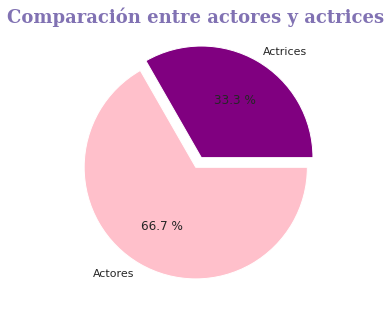

In [ ]:
plt.figure(figsize=(5,7))

sexo = ['Actrices', 'Actores']
apariciones = [134803,270257]
desfase=(0.1,0)
colores=['purple', 'pink']
 
plt.pie(apariciones, labels=sexo, autopct="%0.1f %%", colors=colores, explode=desfase)
 
plt.title('Comparación entre actores y actrices', fontdict={'family': 'serif', 
                    'color' : 'm',
                    'weight': 'bold',
                    'size': 18})
 
plt.show()

Veremos el contraste que hay entre palabras referentes a hombres y mujeres dentro de los plot summaries

In [ ]:
#Hacemos uso de las funciones declaradas antes y enparticular de la función cuenta
cuenta('man')
cuenta('woman')

cuenta('father')
cuenta('mother')

cuenta('boy')
cuenta('girl')

cuenta('men')
cuenta('women')

2766

Visualizando un poco los resultados

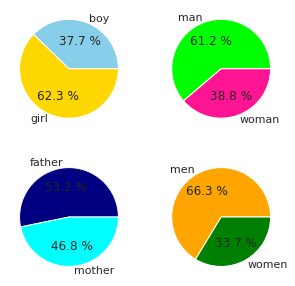

In [ ]:
fig, axs=plt.subplots(2,2, figsize=(5,5))

boygirl=[3499,5773]
axs[0,0].pie(boygirl, labels=['boy','girl'], autopct="%0.1f %%", colors=['skyblue', 'gold'])

menwomen=[10482,6636]
axs[0,1].pie(menwomen, labels=['man', 'woman'], autopct="%0.1f %%", colors=['lime', 'deeppink'])

fathmoth=[9084,7985]
axs[1,0].pie(fathmoth, labels=['father','mother'], autopct="%0.1f %%", colors=['navy', 'cyan'])

manwom=[5449,2766]
axs[1,1].pie(manwom, labels=['men','women'], autopct="%0.1f %%", colors=['orange', 'green'])

plt.show()

Ahora contemos las menciones de ciertos oficios en hombres y mujeres en el dataset de los summaries.

In [ ]:
waiter=cuenta('waiter')
waitress=cuenta('waitress')
mister=cuenta('mister')
miss=cuenta('miss')
actor=cuenta('actor')
actress=cuenta('actress')
businessman=cuenta('businessman')
businesswoman=cuenta('businesswoman')
policeman=cuenta('policeman')
policewoman=cuenta('policewoman')

Comparación visual de los oficios en los plot summaries

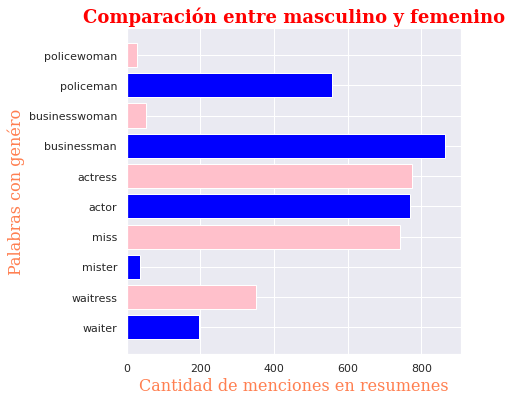

In [ ]:
plt.figure(figsize=(6,6))

eje_x = ['waiter', 'waitress', 'mister', 'miss', 'actor', 'actress', 'businessman', 'businesswoman', 'policeman', 'policewoman']
eje_y = [196,352,36,741,768,773,865,54,556,27]
 
plt.barh(eje_x, eje_y, color=['blue', 'pink'])
 
plt.xlabel('Cantidad de menciones en resumenes', fontdict={'family':'serif', 'color': 'coral', 'size':16})
 
plt.ylabel('Palabras con genéro', fontdict={'family':'serif', 'color': 'coral', 'size':16})
 
plt.title('Comparación entre masculino y femenino',fontdict={'family': 'serif', 
                    'color' : 'red',
                    'weight': 'bold',
                    'size': 18})
 
plt.show()

#¿Y que actor/actriz aparece en más películas?

Hay que limpiar los nombres y homogeneizar los datos igual que antes

In [ ]:
#Quitamos palabras vacías y signos de puntuación
names2=character.map(removeStopWordsFunct)
names=names2.map(removePunctuationsFunct)

In [ ]:
#Formateamos todo a minúsculas
names_min=names.map(lambda x: (x[8].lower()))

In [ ]:
names_min.take(5)

['wanda de jesus',
 'natasha henstridge',
 'ice cube',
 'jason statham',
 'clea duvall']

In [ ]:
#Aplicamos nuevamente el método MapReduce 
character_actor = names_min.map(lambda x:(x,1)).reduceByKey(lambda a,b:a+b)

In [ ]:
character_actor.take(7)

[('ice cube', 33),
 ('clea duvall', 31),
 ('joanna cassidy', 41),
 ('liam waite', 5),
 ('peter jason', 27),
 ('doug mcgrath', 6),
 ('rosemary forsyth', 10)]

Los ordenamos en forma descendiente

In [ ]:
mvp_character=character_actor.sortBy(lambda x: x[1], ascending=False)

Para sorpresa de nadie hay muchas más apariciones de hombres que mujeres. De hecho las primeras 30 apariciones son hombres que varían en los géneros de comedia, doblaje y western. Y no es hasta el top 31 que aparece la primer mujer, Rekha Ganesan. Una clara falta de respeto a Sandra Bullock.

In [ ]:
mvp_character.take(35)

[('', 1229),
 ('mel blanc', 791),
 ('mithun chakraborty', 328),
 ('oliver hardy', 299),
 ('mohanlal', 234),
 ('mammootty', 225),
 ('moe howard', 225),
 ('dharmendra deol', 219),
 ('larry fine', 219),
 ('amitabh bachchan', 206),
 ('prakash raj', 205),
 ('brahmanandam', 204),
 ('kamal haasan', 198),
 ('shakti kapoor', 191),
 ('jagathi sreekumar', 191),
 ('anupam kher', 191),
 ('harold lloyd', 191),
 ('frank welker', 183),
 ('rajnikanth', 178),
 ('john wayne', 178),
 ('nassar', 172),
 ('nedumudi venu', 167),
 ('stan laurel', 165),
 ('amrish puri', 158),
 ('roscoe arbuckle', 158),
 ('paresh rawal', 158),
 ('christopher lee', 152),
 ('harry carey', 149),
 ('gulshan grover', 148),
 ('prem chopra', 138),
 ('rekha ganesan', 135),
 ('sanjay dutt', 134),
 ('jackie shroff', 132),
 ('chiranjeevi', 131),
 ('asrani', 131)]

Que nombres aparecen en más plot summaries? Para ello hacemos el mismo procedimiento usando la función cuenta.

In [ ]:
#Nombres de la mejor generación en LCD 
cuenta('enrique')
cuenta('hugo')
cuenta('daniel')
cuenta('blanca')
cuenta('gibran')
cuenta('marcela')
cuenta('marlene')
cuenta('fernando')
cuenta('pablo')
cuenta('luis')
cuenta('manuel')
cuenta('edgar')
cuenta('camila')
cuenta('yeudiel')
cuenta('guillermo')
cuenta('ivan')
cuenta('lucas')
cuenta('eduardo')
cuenta('octavio')
cuenta('didier')
cuenta('bruce')
cuenta('cesar')
cuenta('rodrigo')
cuenta('jesus')

203

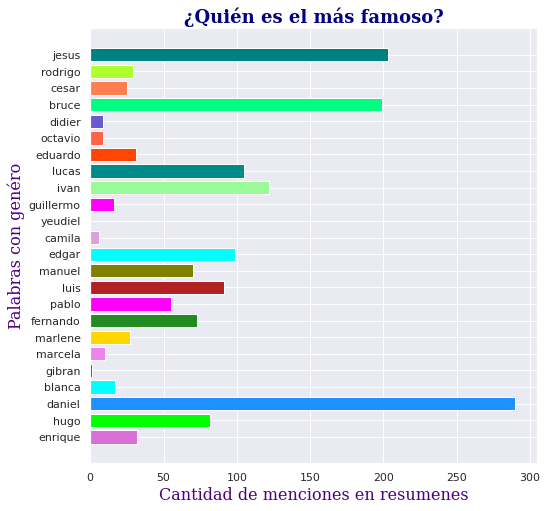

In [ ]:
#Veamoslo en una bonita y colorida gráfica

plt.figure(figsize=(8,8))

eje_x = ['enrique', 'hugo', 'daniel', 'blanca', 'gibran', 'marcela', 'marlene', 'fernando', 'pablo', 'luis','manuel','edgar','camila','yeudiel',
         'guillermo','ivan','lucas','eduardo','octavio','didier','bruce','cesar','rodrigo','jesus']

eje_y = [32,82,290,17,1,10,27,73,55,91,70,99,6,0,16,122,105,31,9,9,199,25,29,203]
 
plt.barh(eje_x, eje_y, color=['orchid', 'lime','dodgerblue','cyan','red','violet','gold','forestgreen','magenta','firebrick','olive','aqua','plum',
                              'yellow','fuchsia','palegreen','darkcyan','orangered','tomato','slateblue','springgreen','coral','greenyellow','teal'])
 
plt.xlabel('Cantidad de menciones en resumenes', fontdict={'family':'serif', 'color': 'indigo', 'size':16})
 
plt.ylabel('Palabras con genéro', fontdict={'family':'serif', 'color': 'indigo', 'size':16})
 
plt.title('¿Quién es el más famoso?',fontdict={'family': 'serif', 
                    'color' : 'navy',
                    'weight': 'bold',
                    'size': 18})
 
plt.show()